In [431]:
import pandas as pd
import plotly.graph_objs as go 
import matplotlib.pyplot as plt
import shap
shap.initjs()


In [432]:
apple = pd.read_csv("../data/AAPL.csv")
amazon = pd.read_csv("../data/AMZN.csv")
berkshire = pd.read_csv("../data/BRK-B.csv")
google = pd.read_csv("../data/GOOG.csv")
meta = pd.read_csv("../data/META.csv")
microsoft = pd.read_csv("../data/MSFT.csv")
nvidia = pd.read_csv("../data/NVDA.csv")
tesla = pd.read_csv("../data/TSLA.csv")
unitedhealth = pd.read_csv("../data/UNH.csv")
exxon = pd.read_csv("../data/XOM.csv")

In [433]:
df_names = ['apple', 'amazon', 'berkshire', 'google', 'meta', 'microsoft', 'nvidia', 'tesla', 'unitedhealth', 'exxon']
merged_df = globals()[df_names[0]][['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

for df_name in df_names[1:]:
    merged_df = pd.merge(merged_df, globals()[df_name], on='Date', how='outer', suffixes=('', f'_{df_name}'))


cours_boursiers = merged_df.rename(columns={"Open": "Open_apple",
                                      "High": "High_apple",
                                      "Low": "Low_apple",
                                      "Close": "Close_apple",
                                      "Adj Close": "Adj Close_apple",
                                      "Volume":"Volume_apple"})


cours_boursiers.columns = cours_boursiers.columns.str.replace(" ","_")
cours_boursiers.head()

,Date,Open_apple,High_apple,Low_apple,Close_apple,Adj_Close_apple,Volume_apple,Open_amazon,High_amazon,Low_amazon,...,Low_unitedhealth,Close_unitedhealth,Adj_Close_unitedhealth,Volume_unitedhealth,Open_exxon,High_exxon,Low_exxon,Close_exxon,Adj_Close_exxon,Volume_exxon
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769093,560518000,12.8040,12.9050,12.6630,...,54.009998,54.540001,46.073730,5358100,87.790001,88.720001,87.239998,88.709999,56.165756,16143700
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557426,352965200,12.8635,13.0440,12.8185,...,51.849998,51.990002,43.919567,14413200,88.459999,88.889999,88.160004,88.550003,56.064438,13268200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096228,594333600,12.8790,12.9900,12.8325,...,52.060001,52.090000,44.004032,10458000,88.500000,89.089996,88.370003,88.959999,56.324017,11427900
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001543,484156400,13.1485,13.4865,13.1335,...,51.549999,52.090000,44.004032,7804500,88.309998,88.489998,87.570000,87.930000,55.671913,11799800
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044611,458707200,13.3535,13.4490,13.1785,...,51.360001,51.400002,43.421143,8196200,87.820000,88.480003,87.290001,88.480003,56.020119,14226400


## Feature engineering

In [434]:

cours_boursiers['Date'] = pd.to_datetime(cours_boursiers['Date'])

cours_boursiers = cours_boursiers.sort_values(by='Date')
stock_columns = ['apple', 'amazon', 'berkshire', 'google', 'meta', 'microsoft', 'nvidia', 'tesla', 'unitedhealth', 'exxon']

for stock in stock_columns:

    cours_boursiers[f'Volatility_HighLow_{stock}_10days'] = cours_boursiers[f'High_{stock}'].rolling(window=10).std() / cours_boursiers[f'Low_{stock}'].rolling(window=10).mean()    
    cours_boursiers[f'Delta_HighLow_{stock}_10days'] = cours_boursiers[f'High_{stock}'].diff(periods=10) / cours_boursiers[f'Low_{stock}'].diff(periods=10)
    cours_boursiers[f'Delta_OpenClose_{stock}_10days'] = cours_boursiers[f'Open_{stock}'].diff(periods=10) / cours_boursiers[f'Close_{stock}'].diff(periods=10)
    cours_boursiers[f'Delta_Volume_{stock}_10days'] = cours_boursiers[f'Volume_{stock}'].diff(periods=10)


In [435]:
cours_boursiers.shape

(2768, 101)

## Création du portefeuille

In [436]:
stock_columns = ['apple', 'amazon', 'berkshire', 'google', 'meta', 'microsoft', 'nvidia', 'tesla', 'unitedhealth', 'exxon']

for stock in stock_columns:
    cours_boursiers[f"{stock}_return"] = cours_boursiers[f"Close_{stock}"].pct_change()

portfolio_returns = cours_boursiers[[f"{stock}_return" for stock in stock_columns]].copy()

portfolio_returns['Portfolio'] = portfolio_returns.mean(axis=1)

initial_capital = 1000

portfolio_returns['Portfolio Value'] = initial_capital * (1 + portfolio_returns['Portfolio']).cumprod()

portfolio_returns = portfolio_returns.iloc[1:]

cours_boursiers = pd.concat([cours_boursiers, portfolio_returns], axis=1)
cours_boursiers.columns = cours_boursiers.columns.str.replace(" ","_")
cours_boursiers.head()

,Date,Open_apple,High_apple,Low_apple,Close_apple,Adj_Close_apple,Volume_apple,Open_amazon,High_amazon,Low_amazon,...,berkshire_return,google_return,meta_return,microsoft_return,nvidia_return,tesla_return,unitedhealth_return,exxon_return,Portfolio,Portfolio_Value
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769093,560518000,12.8040,12.9050,12.6630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557426,352965200,12.8635,13.0440,12.8185,...,0.004507,0.000581,-0.008214,-0.013396,0.000786,-0.016685,-0.046755,-0.001804,-0.008906,991.094425
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096228,594333600,12.8790,12.9900,12.8325,...,0.002457,0.019760,0.035650,-0.018716,0.032993,-0.010642,0.001923,0.004630,0.004279,995.335697
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001543,484156400,13.1485,13.4865,13.1335,...,-0.004262,-0.004363,0.022949,-0.001870,-0.028897,-0.001744,0.000000,-0.011578,0.000028,995.363207
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044611,458707200,13.3535,13.4490,13.1785,...,0.003852,-0.001974,-0.012237,-0.005245,-0.021926,-0.019220,-0.013246,0.006255,-0.006880,988.515396


In [437]:
fig = go.Figure()

# Ajout de la série financière
fig.add_trace(go.Scatter(x = cours_boursiers.index, 
                         y = cours_boursiers['Portfolio'], 
                         mode = 'lines',
                         name ='Évolution financière ptf', 
                         fill = "tozeroy"))

# Mise à jour des titres
fig.update_layout(title="Évolution de la valeur de ptf",
                  xaxis_title='Date',
                  yaxis_title='Valeur')

# Affichage du graphique
fig.show()

## Création de Y

- y = X + horizon de prévision
- horizon de prévision = 2 semaines pour commencer


In [438]:
duplicate_cols = cours_boursiers.columns[cours_boursiers.columns.duplicated()]
cours_boursiers.drop(columns=duplicate_cols, inplace=True)

In [439]:
val = cours_boursiers.columns[1:50].tolist()

In [440]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

predictor_column = 'Portfolio'

horizon = 15 # 15j

#for stock in stock_columns:
#    cours_boursiers[f"{stock}_return"] = cours_boursiers[f"Close_{stock}"].pct_change()

cours_boursiers['Target'] = cours_boursiers[predictor_column].shift(horizon)

# Supprimez les lignes où la cible est NaN (dû au décalage)
cours_boursiers = cours_boursiers.dropna()

cours_boursiers.reset_index(drop=True, inplace=True)

## data viz

## Feature selection

In [450]:
correlations = cours_boursiers.corr()[['Target']].sort_values(by='Target', ascending=False)
selected_features = correlations[abs(correlations["Target"]) >= 0.2].index


In [442]:
val = ['Adj_Close_microsoft', 'Low_microsoft',
       'Close_microsoft', 'High_microsoft', 'Open_microsoft',
       'Adj_Close_apple', 'Low_apple', 'Close_apple', 'Open_apple',
       'High_apple', 'High_google', 'Adj_Close_google', 'Close_google',
       'Open_google', 'Low_google', 'Adj_Close_unitedhealth', 'High_berkshire',
       'Adj_Close_berkshire', 'Close_berkshire', 'Low_berkshire',
       'Low_unitedhealth', 'Open_berkshire', 'Close_unitedhealth',
       'High_unitedhealth', 'Open_unitedhealth', 'High_nvidia', 'Close_nvidia',
       'Adj_Close_nvidia', 'Open_nvidia', 'Low_nvidia', 'Low_tesla',
       'Adj_Close_tesla', 'Close_tesla', 'High_tesla', 'Open_tesla',
       'High_amazon', 'Adj_Close_amazon', 'Close_amazon', 'Open_amazon',
       'Low_amazon', 'High_meta', 'Adj_Close_meta', 'Close_meta', 'Open_meta',
       'Low_meta', 'Adj_Close_exxon', 'Volume_exxon',
       'Volatility_HighLow_exxon_10days', 'Volatility_HighLow_nvidia_10days',
       'Volatility_HighLow_google_10days', 'Volume_unitedhealth',
       'Volume_google', 'Volume_apple']


In [443]:
train_size = int(0.8 * len(cours_boursiers))
train_data, test_data = cours_boursiers[:train_size], cours_boursiers[train_size:]

X_train, y_train = train_data.drop(columns=["Target", "Date"], axis = 1), train_data['Target']

X_test, y_test = test_data.drop(columns=["Target", "Date"], axis = 1), test_data['Target']

model = XGBRegressor()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_squared_error(y_test, predictions)
print(f'Mean squared Error: {mae}')

XGBoostError: [10:09:08] /Users/runner/work/xgboost/xgboost/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000168a3c994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000168b391f8 void xgboost::GHistIndexMatrix::SetIndexData<xgboost::data::ArrayAdapterBatch, unsigned char, xgboost::common::Index::CompressBin<unsigned char>, xgboost::data::IsValidFunctor&>(xgboost::common::Span<unsigned char, 18446744073709551615ul>, unsigned long, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, unsigned long, xgboost::data::ArrayAdapterBatch const&, xgboost::data::IsValidFunctor&, unsigned long, xgboost::common::Index::CompressBin<unsigned char>&&) + 308
  [bt] (2) 3   libxgboost.dylib                    0x0000000168b38e20 auto xgboost::common::DispatchBinType<void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>)::'lambda'(xgboost::data::ArrayAdapterBatch)>(xgboost::common::BinTypeSize, xgboost::data::ArrayAdapterBatch&&) + 132
  [bt] (3) 4   libxgboost.dylib                    0x0000000168b37e58 void xgboost::GHistIndexMatrix::PushBatchImpl<xgboost::data::ArrayAdapterBatch, xgboost::data::IsValidFunctor&>(int, xgboost::data::ArrayAdapterBatch const&, unsigned long, xgboost::data::IsValidFunctor&, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>) + 292
  [bt] (4) 5   libxgboost.dylib                    0x0000000168b37944 void xgboost::GHistIndexMatrix::PushAdapterBatch<xgboost::data::ArrayAdapterBatch>(xgboost::Context const*, unsigned long, unsigned long, xgboost::data::ArrayAdapterBatch const&, float, xgboost::common::Span<xgboost::FeatureType const, 18446744073709551615ul>, double, unsigned long) + 292
  [bt] (5) 6   libxgboost.dylib                    0x0000000168b2e938 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 8112
  [bt] (6) 7   libxgboost.dylib                    0x0000000168b2c330 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1072
  [bt] (7) 8   libxgboost.dylib                    0x0000000168aea3e4 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 140
  [bt] (8) 9   libxgboost.dylib                    0x0000000168a464ac XGQuantileDMatrixCreateFromCallback + 516



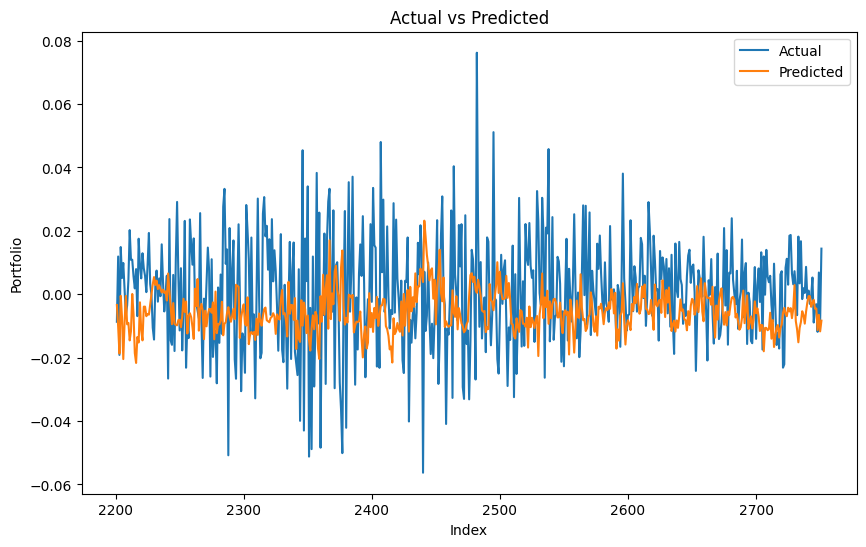

In [ ]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Actual'], label='Actual')
plt.plot(results.index, results['Predicted'], label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel(predictor_column)
plt.legend()
plt.show()

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

[10:03:53] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


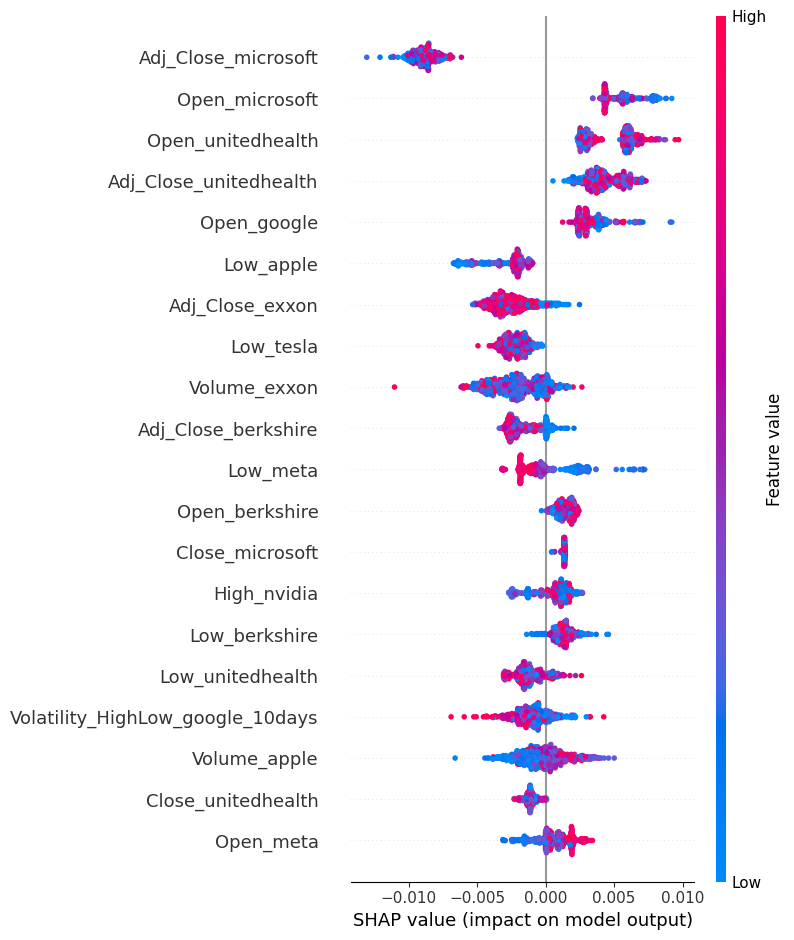

In [ ]:
shap.summary_plot(shap_values, X_test)